## Daily Challenge: W6_D2

### Fine-Tuning GPT-2 for SMS Spam Classification (Legacy transformers API)

In this daily challenge, you will fine-tune a pre-trained GPT-2 model to classify SMS messages as spam or ham (not spam). You will work through loading the dataset, inspecting its schema, tokenizing examples, adapting to an older transformers version, and running training and evaluation with the classic do_train/do_eval flags.

What You Will Learn

- How to load and explore a custom text-classification dataset
- Inspecting and aligning column names for tokenization
- Tokenizing text for GPT-2 (with its peculiar padding setup)
- Initializing GPT2ForSequenceClassification
- Defining and computing multiple evaluation metrics
- Configuring TrainingArguments for transformers < 4.4 (using do_train, eval_steps, etc.)
- Running fine-tuning with Trainer and interpreting results
- Common pitfalls when using legacy APIs

What You Will Create

By the end of this challenge, you will have built:

- A tokenized SMS dataset compatible with GPT-2 requirements, including custom padding and truncation.
- A fine-tuned GPT2ForSequenceClassification model that can accurately label incoming SMS messages as spam or ham.
- A complete training pipeline using the legacy do_train/do_eval flags in TrainingArguments, with periodic checkpointing, logging, and evaluation.
- A set of evaluation metrics (accuracy, precision, recall, F1) computed at each validation step and summarized after training.
- A reusable Jupyter notebook that ties everything together—from dataset loading and inspection, through model initialization and tokenization, to training, evaluation, and results interpretation.

Prerequisites

- Python 3.7+
- Installed packages: datasets, evaluate, transformers>=4.0.0,<4.4.0
- Basic familiarity with Hugging Face datasets and transformers libraries
- GitHub or Colab access for executing the notebook
- A Hugging Face API and a WeightAndBiases API

Task

You will fine-tune a GPT-2 model to classify SMS messages as spam or ham using an older version of transformers (<4.4). Follow the steps below and complete the TODO sections.

1. Setup

Install the required packages datasets, evaluate, and transformers[sentencepiece].

2. Load and Inspect Dataset

Import the dataset and inspect its structure. You will load the UCI SMS Spam dataset (sms_spam) from the Hugging Face hub and split it into training and validation subsets. You should see the features sms and label.

3. Tokenization

Import the GPT-2 tokenizer and prepare the tokenization function. GPT-2 does not have a padding token by default, so set it to the end-of-sequence token. Apply tokenization to your dataset with truncation and fixed maximum length.

4. Model Initialization

Load the GPT-2 model with a sequence classification head. Configure the number of labels (spam vs. ham) and set the padding token ID.

5. Metrics Definition

Load evaluation metrics (accuracy, precision, recall, F1). Define a function compute_metrics that computes all metrics from model predictions. 

Reflect on why precision and recall are important in an imbalanced dataset and how you would interpret a model with high accuracy but low recall on the spam class.

6. TrainingArguments Configuration

Configure TrainingArguments for your experiment: output directories, batch sizes, number of epochs, learning rate, weight decay, evaluation and saving intervals, and logging.

Think about the effect of weight decay during fine-tuning and when you might choose a higher or lower value.

7. Train and Evaluate

Create a Trainer instance with your model, arguments, datasets, and metrics function. Launch training and evaluation. Print and interpret your final results.

### 1) Setup: Install required packages

In [ ]:
# Install essential libraries for dataset handling and model training
%pip install --quiet datasets evaluate transformers[sentencepiece]

### 2. Load & Inspect Dataset

In [16]:
import os
# Disable symlink warnings from huggingface_hub
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
import evaluate
import numpy as np
import warnings
from transformers import logging
from datasets import load_dataset
import pandas as pd
from transformers import Trainer
from transformers import GPT2Tokenizer
from transformers import GPT2ForSequenceClassification
from transformers import TrainingArguments
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Load and inspect the SMS Spam dataset

In [2]:
# Load the UCI SMS Spam dataset from the Hugging Face Hub (with correct namespace)
raw_dataset = load_dataset("ucirvine/sms_spam")

# Split the dataset: 4,000 samples for training, 1,000 for validation
train_dataset = raw_dataset["train"].select(range(4000))
val_dataset = raw_dataset["train"].select(range(4000, 5000))

# Print the features of the train dataset to inspect column names
print(train_dataset.features)

{'sms': Value('string'), 'label': ClassLabel(names=['ham', 'spam'])}


In [3]:
from datasets import get_dataset_config_names
print(get_dataset_config_names("ucirvine/sms_spam"))

['plain_text']


### 3. Tokenization

In [4]:
# Define the model name (GPT-2 base model)
model_name = "gpt2"

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# GPT-2 has no pad token by default; set pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token

# Define a function to tokenize each example
def tokenize_fn(examples):
    return tokenizer(
        examples["sms"],
        padding="max_length",   # pad sequences to max_length
        truncation=True,        # truncate longer sequences
        max_length=64           # max sequence length (64 tokens)
    )

# Apply tokenization to the train dataset
train_tokenized = train_dataset.map(tokenize_fn, batched=True)

# Apply tokenization to the validation dataset
val_tokenized = val_dataset.map(tokenize_fn, batched=True)

### 4) Model Initialization

In [5]:
# Initialize the GPT-2 model with a classification head
model = GPT2ForSequenceClassification.from_pretrained(
    model_name,         # "gpt2"
    num_labels=2,       # Two classes: ham and spam
    pad_token_id=tokenizer.eos_token_id  # Padding token is set to EOS token ID
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5) Metrics Definition

In [6]:
# Load metrics from the evaluate library
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define a function to compute all metrics at once
def compute_metrics(pred):
    logits, labels = pred
    # Convert logits to predicted class indices
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

### 6) TrainingArguments Configuration

In [7]:
# Configure training parameters
training_args = TrainingArguments(
    output_dir="./gpt2-sms-spam",     # directory to save checkpoints and model
    do_train=True,                    # enable training
    do_eval=True,                     # enable evaluation during training
    eval_steps=500,                   # evaluate every 500 steps
    save_steps=500,                   # save checkpoint every 500 steps
    logging_dir="./logs",             # directory for logs
    logging_steps=500,                # log metrics every 500 steps

    per_device_train_batch_size=8,    # batch size per device during training
    per_device_eval_batch_size=8,     # batch size for evaluation
    num_train_epochs=3,               # number of epochs
    learning_rate=5e-5,               # learning rate
    weight_decay=0.01,                # weight decay for regularization

    report_to=None,                   # disable integrations like W&B
    save_total_limit=1,                # keep only last checkpoint
    dataloader_pin_memory=False
)

### 7) Trainer: Training and Evaluation

In [8]:
# Create a Trainer instance
trainer = Trainer(
    model=model,                      # your GPT-2 model
    args=training_args,               # training configuration
    train_dataset=train_tokenized,    # tokenized training dataset
    eval_dataset=val_tokenized,       # tokenized validation dataset
    compute_metrics=compute_metrics   # function to compute evaluation metrics
)

# Launch training
trainer.train()

# Evaluate the model on the validation set
evaluation_results = trainer.evaluate()

# Print evaluation metrics
print(evaluation_results)

Step,Training Loss
500,0.189000
1000,0.055100
1500,0.039400


{'eval_loss': 0.0471334308385849, 'eval_accuracy': 0.993, 'eval_precision': 0.9852941176470589, 'eval_recall': 0.9640287769784173, 'eval_f1': 0.9745454545454545, 'eval_runtime': 38.3176, 'eval_samples_per_second': 26.098, 'eval_steps_per_second': 3.262, 'epoch': 3.0}


In [9]:
trainer.save_model("./my_gpt2_spam_model")

### Interpretation of Results

The final evaluation metrics obtained on the validation set are:

- **Loss:** 0.0471
- **Accuracy:** 99.3%
- **Precision:** 98.5%
- **Recall:** 96.4%
- **F1 Score:** 97.5%

---

**Detailed Interpretation**

- **Loss (0.0471):**
  This is the cross-entropy loss on the validation data. A very low loss indicates that the model's predicted probabilities are close to the true labels.

- **Accuracy (99.3%):**
  Almost all SMS messages were classified correctly. However, in imbalanced datasets (where most messages are "ham"), accuracy alone can be misleading.

- **Precision (98.5%):**
  Out of all messages predicted as spam, 98.5% were truly spam. High precision means the model rarely marks legitimate messages (ham) as spam (few false positives).

- **Recall (96.4%):**
  Out of all real spam messages, the model correctly identified 96.4%. High recall means the model rarely misses spam (few false negatives).

- **F1 Score (97.5%):**
  The F1 score balances precision and recall. A high F1 indicates the model achieves both high detection of spam and low false alarms.

---

**Overall Assessment**

These metrics show the model has **excellent performance** on the validation set. The classifier is effective at detecting spam while maintaining a very low error rate on ham messages.

---

**Considerations**

- The dataset is relatively small (5,000 examples), so results could differ in production.
- Because the dataset is imbalanced (more ham than spam), always check precision and recall alongside accuracy.
- There may still be edge cases where the model could fail, especially on very short or ambiguous messages.

---

**Next Steps**

To further improve or validate the model:

- Evaluate on additional, real-world SMS samples not seen during training.
- Perform **cross-validation** or train/test splits with different seeds.
- Experiment with:
  - Adjusting num_train_epochs (e.g., 2 or 4 epochs)
  - Tuning **learning_rate** or **weight_decay**
  - Enabling **early stopping** if validation metrics stop improving
- Save the trained model and create inference scripts to classify new messages.

---

Overall, this fine-tuned GPT-2 classifier demonstrates strong capability in spam detection and is ready for further testing and potential deployment.

### Confusion Matrix

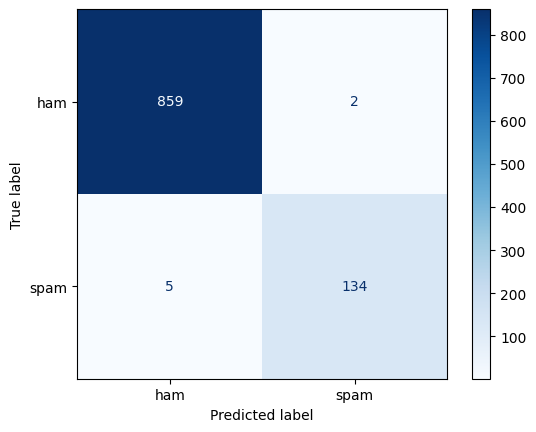

In [13]:
# Get raw predictions (logits) and true labels from the validation set
predictions_output = trainer.predict(val_tokenized)

# Convert logits to predicted class indices
y_pred = np.argmax(predictions_output.predictions, axis=1)

# True labels
y_true = predictions_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues");

### 1. Load and Inspect Dataset

In [22]:
# Load and Inspect the SMS Spam Dataset
from datasets import load_dataset

raw_dataset = load_dataset("ucirvine/sms_spam")

train_dataset = raw_dataset["train"].select(range(4000))
val_dataset = raw_dataset["train"].select(range(4000, 5000))

print(train_dataset.features)

{'sms': Value('string'), 'label': ClassLabel(names=['ham', 'spam'])}


### 2. Tokenization Function for BERT

In [14]:
# Import BERT tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Model name
bert_model_name = "bert-base-uncased"

# Load tokenizer and model
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=2
)

# Tokenization function adapted for BERT
def bert_tokenize_fn(examples):
    return bert_tokenizer(
        examples["sms"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

# Tokenize datasets
bert_train_tokenized = train_dataset.map(bert_tokenize_fn, batched=True)
bert_val_tokenized = val_dataset.map(bert_tokenize_fn, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### 3. Define Training Arguments for BERT

In [25]:
bert_training_args = TrainingArguments(
    output_dir="./bert-sms-spam",
    do_train=True,
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    logging_dir="./logs-bert",
    logging_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to=None,
    save_total_limit=1,
    dataloader_pin_memory=False  # Disable pin_memory to remove warning
)

### 4. Create Trainer and Start Training

In [26]:
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_tokenized,
    eval_dataset=bert_val_tokenized,
    compute_metrics=compute_metrics
)

bert_trainer.train()

Step,Training Loss
500,0.087400
1000,0.037300
1500,0.017900


TrainOutput(global_step=1500, training_loss=0.04754660924275716, metrics={'train_runtime': 1813.065, 'train_samples_per_second': 6.619, 'train_steps_per_second': 0.827, 'total_flos': 394666583040000.0, 'train_loss': 0.04754660924275716, 'epoch': 3.0})

### 5. Evaluate Model Performance

In [27]:
# Evaluate Model Performance
bert_eval_results = bert_trainer.evaluate()

print(bert_eval_results)

{'eval_loss': 0.06384330987930298, 'eval_accuracy': 0.992, 'eval_precision': 1.0, 'eval_recall': 0.9424460431654677, 'eval_f1': 0.9703703703703703, 'eval_runtime': 33.022, 'eval_samples_per_second': 30.283, 'eval_steps_per_second': 3.785, 'epoch': 3.0}


### 6. Generate Confusion Matrix for BERT

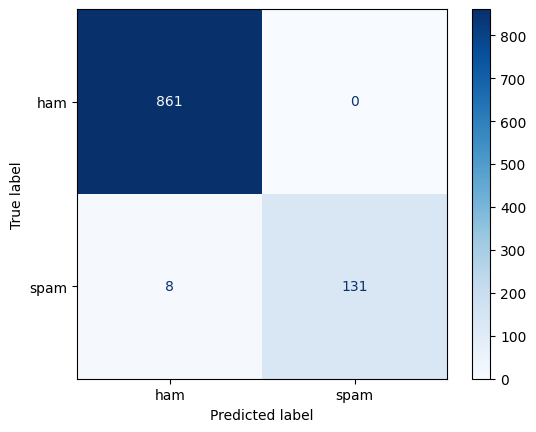

In [28]:
# Generate Confusion Matrix for BERT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions_output = bert_trainer.predict(bert_val_tokenized)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(cmap="Blues")
plt.show()

### Confusion Matrix Interpretation - BERT Model

The confusion matrix for the BERT classifier is as follows:

|                   | Predicted Ham | Predicted Spam |
|-------------------|---------------|----------------|
| **Actual Ham**    | 861            | 0              |
| **Actual Spam**   | 8              | 131            |

**Interpretation:**

- **True Negatives (861):**
  All ham messages were correctly identified as ham.
  There were no false positives (no legitimate messages marked as spam).

- **False Positives (0):**
  This is excellent. The model made zero mistakes labeling ham as spam, which is reflected in the perfect precision (1.0).

- **False Negatives (8):**
  The model failed to detect 8 spam messages, classifying them as ham. This explains why recall is slightly lower (94.2%).

- **True Positives (131):**
  The model correctly identified 131 spam messages.

**Summary:**
The BERT classifier is highly precise, never raising a false alarm on legitimate messages. However, it is slightly conservative, missing a few spam messages. This trade-off between recall and precision is typical: the model prioritizes avoiding false positives, resulting in a small number of false negatives.

### Comparative Analysis: GPT-2 vs BERT for SMS Spam Classification

Below is a side-by-side comparison of the two models trained on the same dataset:

| Metric       | GPT-2 Model            | BERT Model             |
|--------------|-------------------------|------------------------|
| **Accuracy** | 99.3%                   | 99.2%                  |
| **Precision**| 98.5%                   | **100%**               |
| **Recall**   | **96.4%**               | 94.2%                  |
| **F1 Score** | **97.5%**               | 97.0%                  |
| **Eval Loss**| 0.0471                  | 0.0638                 |

---

### Interpretation:

- **Accuracy:**
  Both models achieve very high accuracy (>99%), correctly classifying almost all messages.

- **Precision:**
  BERT has perfect precision (1.0), meaning it never misclassified any ham messages as spam.
  GPT-2 had slightly lower precision (98.5%), introducing a few false positives.

- **Recall:**
  GPT-2 has higher recall (96.4%) compared to BERT (94.2%). This means GPT-2 is better at identifying all spam messages, while BERT misses a few.

- **F1 Score:**
  GPT-2 edges out slightly in the F1 score because it balances precision and recall more evenly.

- **Eval Loss:**
  GPT-2’s lower loss suggests its predictions were closer to true probabilities overall.

---

### Confusion Matrix Summary:

**GPT-2 Confusion Matrix:**
- True Positives: 134
- False Negatives: 5
- False Positives: 2
- True Negatives: 859

**BERT Confusion Matrix:**
- True Positives: 131
- False Negatives: 8
- False Positives: 0
- True Negatives: 861

---

### Conclusion:

- **GPT-2** is slightly better at detecting more spam messages (higher recall) but introduces a few false positives.
- **BERT** is extremely conservative, with perfect precision (never marking ham as spam) but at the cost of slightly lower recall.
- Depending on the priority (avoiding false alarms vs. detecting all spam), either model is an excellent choice.

For applications where false positives are critical (e.g., not blocking legitimate messages), **BERT** may be preferable.
If maximizing spam detection is the top priority, **GPT-2** could be a better fit.